In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import polars as pl
import datetime
import altair as alt

In [2]:
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [3]:
# Perform depth-first search (DFS) to find all conjugated bond paths
def dfs(graph, bond_idx, visited):
    visited.add(bond_idx)
    max_chain = []
    for neighbor, is_connected in enumerate(graph[bond_idx]):
        if is_connected and neighbor not in visited:
            chain = dfs(graph, neighbor, visited)
            if len(chain) > len(max_chain):
                max_chain = chain
    visited.remove(bond_idx)
    return [bond_idx] + max_chain

In [4]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Geometry import Point2D
from IPython.display import SVG  # For displaying SVG directly in Jupyter notebooks

# Function to label bond indices on a molecule
def label_bonds(mol):
    # Generate 2D coordinates for visualization
    Chem.rdDepictor.Compute2DCoords(mol)

    # Define image size and initialize an SVG drawer
    drawer = Draw.MolDraw2DSVG(300, 300)

    # Draw the molecule first
    drawer.DrawMolecule(mol)

    # Add bond numbers in red
    for bond in mol.GetBonds():
        idx = bond.GetIdx()
        begin_atom_pos = mol.GetConformer().GetAtomPosition(bond.GetBeginAtomIdx())
        end_atom_pos = mol.GetConformer().GetAtomPosition(bond.GetEndAtomIdx())

        # Calculate midpoint of bond
        mid_x = (begin_atom_pos.x + end_atom_pos.x) / 2
        mid_y = (begin_atom_pos.y + end_atom_pos.y) / 2

        # Offset the y coordinate to move the label just above the bond
        offset_y = 1.1  # Adjust this value to control how far above the bond the label is
        mid_point = Point2D(mid_x, mid_y + offset_y)

        # Set label color to red and add bond index at the offset midpoint
        drawer.SetColour((1.0, 0.0, 0.0))  # Red color (R, G, B)
        drawer.DrawString(str(idx), mid_point)

    # Finish drawing
    drawer.FinishDrawing()

    # Get the SVG text
    svg = drawer.GetDrawingText()

    # Display the SVG image (if you're in a Jupyter notebook)
    display(SVG(svg))

    # Save the SVG to a file (optional)
    with open("molecule_with_bond_numbers.svg", "w") as f:
        f.write(svg)

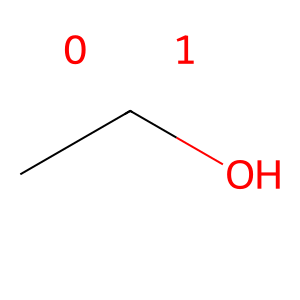

In [5]:
label_bonds(Chem.MolFromSmiles("CCO"))

In [6]:
from rdkit import Chem
import numpy as np

def get_longest_conjugated_bond_chain(mol):
    num_bonds = mol.GetNumBonds()
    
    # Create a list to store conjugated bond indices
    conjugated_bonds = [bond.GetIdx() for bond in mol.GetBonds() if bond.GetIsConjugated()]
    num_conjugated_bonds = len(conjugated_bonds)
    # print(f"  # bonds: {num_bonds} total, {num_conjugated_bonds} conjugated.")
    
    if not conjugated_bonds:
        return []  # No conjugated bonds found, return empty list
    
    # Build a subgraph of only conjugated bonds
    bond_matrix = np.zeros((len(conjugated_bonds), len(conjugated_bonds)), dtype=int)
    
    # Populate the bond adjacency matrix for conjugated bonds
    for i, bond_i in enumerate(conjugated_bonds):
        bond_i_obj = mol.GetBondWithIdx(bond_i)
        for j, bond_j in enumerate(conjugated_bonds):
            if i != j:
                bond_j_obj = mol.GetBondWithIdx(bond_j)
                # Check if two conjugated bonds share an atom
                if len(set([bond_i_obj.GetBeginAtomIdx(), bond_i_obj.GetEndAtomIdx()]) & 
                       set([bond_j_obj.GetBeginAtomIdx(), bond_j_obj.GetEndAtomIdx()])) > 0:
                    bond_matrix[i, j] = 1
                    bond_matrix[j, i] = 1

    # Find connected components in the conjugated bond subgraph
    def find_connected_component(graph, start_bond, visited):
        stack = [start_bond]
        connected_component = []
        
        while stack:
            bond_idx = stack.pop()
            if bond_idx not in visited:
                visited.add(bond_idx)
                connected_component.append(bond_idx)
                
                # Add all neighbors to the stack for traversal
                for neighbor, is_connected in enumerate(graph[bond_idx]):
                    if is_connected and neighbor not in visited:
                        stack.append(neighbor)
        
        return connected_component

    # Initialize variables to store the longest conjugated bond chain
    visited = set()
    longest_bond_chain = []

    # Traverse the graph and find the largest connected component
    for start_bond in range(len(conjugated_bonds)):
        if start_bond not in visited:
            bond_chain = find_connected_component(bond_matrix, start_bond, visited)
            if len(bond_chain) > len(longest_bond_chain):
                longest_bond_chain = bond_chain

    # Convert subgraph bond indices back to the original bond indices
    conjugated_bonds_out = [conjugated_bonds[i] for i in longest_bond_chain]
    conjugated_bonds_out.sort()
    return conjugated_bonds_out

In [7]:
# # Beta carotene
# smiles = "CC2(C)CCCC(\C)=C2\C=C\C(\C)=C\C=C\C(\C)=C\C=C\C=C(/C)\C=C\C=C(/C)\C=C\C1=C(/C)CCCC1(C)C"
# mol = Chem.MolFromSmiles(smiles)
# longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
# print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")

# Draw.MolToImage(
#     mol,
#     highlightBonds=longest_conjugated_bond_chain,
#     highlightColor=(0,1,0),
#     )

Longest conjugated bond chain length is 16 with bond indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


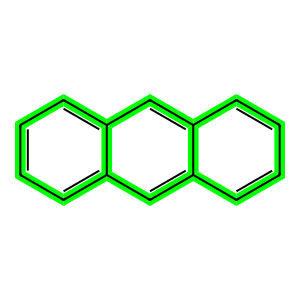

In [8]:
# Anthracene
smiles = "c1ccc2cc3ccccc3cc2c1"
mol = Chem.MolFromSmiles(smiles)
longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")
Draw.MolToImage(
    mol,
    highlightBonds=longest_conjugated_bond_chain,
    highlightColor=(0,1,0),
    )

In [9]:
df = pl.read_csv("../data/DB for chromophore_Sci_Data_rev02.csv")

In [10]:
df.head()

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str
1,"""N#Cc1cc2ccc(O)cc2oc1=O""","""O""",355.0,410.0,2.804262,NaN,NaN,NaN,NaN,NaN,NaN,187.1537,"""DOI: 10.1021/acs.jpcb.5b09905"""
2,"""N#Cc1cc2ccc([O-])cc2oc1=O""","""O""",408.0,450.0,3.961965,NaN,NaN,NaN,NaN,NaN,43.0,186.14576,"""DOI: 10.1021/acs.jpcb.5b09905"""
3,"""CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(…","""ClC(Cl)Cl""",526.0,535.0,3.602954,NaN,NaN,NaN,NaN,NaN,NaN,1061.54348,"""https://doi.org/10.1002/smll.2…"
4,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CC#N""",514.0,553.72,3.81,NaN,NaN,NaN,NaN,NaN,67.4,350.42028,"""https://doi.org/10.1016/j.snb.…"
5,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CS(C)=O""",524.0,555.0,4.7,NaN,NaN,NaN,NaN,58.0,50.0,350.42028,"""https://doi.org/10.1016/j.snb.…"


In [13]:
def mol_props(sml, sml_to_match="C#CC1=C2C=CC=CC2=C(C#C)C2=CC=CC=C12"):
    """
    Convert SMILES to an RDKit molecule, then calculate various properties of it
    :returns: dictionary of molecular properties
    :param sml: SMILES to convert to a molecule
    """
    mol = Chem.MolFromSmiles(sml)
    CanonicalSMILES = Chem.MolToSmiles(mol)
    longest_bond_indices = get_longest_conjugated_bond_chain(mol)
    length = len(longest_bond_indices)
    mol_to_match = Chem.MolFromSmiles(sml_to_match)
    has_match = mol.HasSubstructMatch(mol_to_match)
    matches = mol.GetSubstructMatches(mol_to_match)
    # print(f"matches=")
    match_count = len(matches)

    # print(f"{mol=}, {longest=}")
    return dict(
        CanonicalSMILES=CanonicalSMILES,
        longest_bond_indices=longest_bond_indices,
        longest_bond_length=length,
        has_match = has_match,
        num_match = match_count,
        # matches = matches,
        )

Break

In [14]:
tag = 19444
df_filtered = df.filter(Tag=tag)
# print(df_filtered)
try:
   df = df.drop("CanonicalSMILES", "longest_bond_indices", "longest_bond_length", "has_match", "num_match", "matches")
except:
   pass
# df = df_filtered.with_columns(
df = df.with_columns(
   molecular_props = pl.col('Chromophore').map_elements(mol_props, return_dtype=pl.Struct)
).unnest('molecular_props')
df.head()

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,CanonicalSMILES,longest_bond_indices,longest_bond_length,has_match,num_match
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,list[i64],i64,bool,i64
1,"""N#Cc1cc2ccc(O)cc2oc1=O""","""O""",355.0,410.0,2.804262,NaN,NaN,NaN,NaN,NaN,NaN,187.1537,"""DOI: 10.1021/acs.jpcb.5b09905""","""N#Cc1cc2ccc(O)cc2oc1=O""","[0, 1, … 14]",15,false,0
2,"""N#Cc1cc2ccc([O-])cc2oc1=O""","""O""",408.0,450.0,3.961965,NaN,NaN,NaN,NaN,NaN,43.0,186.14576,"""DOI: 10.1021/acs.jpcb.5b09905""","""N#Cc1cc2ccc([O-])cc2oc1=O""","[0, 1, … 14]",15,false,0
3,"""CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(…","""ClC(Cl)Cl""",526.0,535.0,3.602954,NaN,NaN,NaN,NaN,NaN,NaN,1061.54348,"""https://doi.org/10.1002/smll.2…","""CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(…","[24, 25, … 84]",36,false,0
4,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CC#N""",514.0,553.72,3.81,NaN,NaN,NaN,NaN,NaN,67.4,350.42028,"""https://doi.org/10.1016/j.snb.…","""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","[0, 1, … 30]",31,false,0
5,"""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","""CS(C)=O""",524.0,555.0,4.7,NaN,NaN,NaN,NaN,58.0,50.0,350.42028,"""https://doi.org/10.1016/j.snb.…","""[O-]c1c(-c2nc3ccccc3s2)cc2ccc3…","[0, 1, … 30]",31,false,0


In [17]:
df_matches = df.filter(pl.col("num_match") > 0)
df_matches

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,CanonicalSMILES,longest_bond_indices,longest_bond_length,has_match,num_match
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,list[i64],i64,bool,i64
18923,"""CCCCCCCCn1c(=O)c2cc3c(C#Cc4ccc…","""ClC(Cl)Cl""",582.0,641.0,3.4,0.53,4.518514,NaN,NaN,NaN,NaN,1075.36204,"""DOI: 10.1021/acs.joc.6b00364""","""CCCCCCCCn1c(=O)c2cc3c(C#Cc4ccc…","[8, 9, … 91]",76,true,1
19352,"""COc1ccc(C#Cc2c3ccccc3c(C#Cc3cc…","""ClCCl""",473.0,492.0,2.9,0.66,4.623249,NaN,NaN,NaN,53.8,438.52468,"""DOI: 10.1021/jo501696d""","""COc1ccc(C#Cc2c3ccccc3c(C#Cc3cc…","[1, 2, … 37]",36,true,1
19355,"""COc1ccc(C#Cc2c3ccccc3c(C#Cc3cc…","""ClCCl""",520.0,538.0,5.3,0.75,4.562293,NaN,NaN,NaN,27.5,508.63956,"""DOI: 10.1021/jo501696d""","""COc1ccc(C#Cc2c3ccccc3c(C#Cc3cc…","[1, 2, … 42]",40,true,1
19358,"""COc1ccc(C#Cc2c3cc4cc(C)sc4cc3c…","""ClCCl""",573.0,590.0,7.7,0.92,4.596597,NaN,NaN,NaN,28.2,578.75444,"""DOI: 10.1021/jo501696d""","""COc1ccc(C#Cc2c3cc4cc(C)sc4cc3c…","[1, 2, … 47]",44,true,1
19361,"""COc1ccc(C#Cc2c3ccccc3c(C#Cc3cc…","""ClCCl""",559.0,576.0,7.0,0.85,4.519828,NaN,NaN,NaN,28.2,488.58456,"""DOI: 10.1021/jo501696d""","""COc1ccc(C#Cc2c3ccccc3c(C#Cc3cc…","[1, 2, … 42]",41,true,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
20176,"""CC(C)[Si](C#Cc1ccc(C#Cc2c3cc4c…","""ClCCl""",659.0,668.0,NaN,0.12,NaN,NaN,NaN,NaN,NaN,739.20452,"""DOI: 10.1021/ol801464k""","""CC(C)[Si](C#Cc1ccc(C#Cc2c3cc4c…","[4, 5, … 58]",39,true,1
20177,"""CC(C)[Si](C#Cc1c2cc3ccccc3cc2c…","""ClCCl""",654.0,667.0,NaN,0.06,NaN,NaN,NaN,NaN,NaN,626.83578,"""DOI: 10.1021/ol801464k""","""CC(C)[Si](C#Cc1c2cc3ccccc3cc2c…","[4, 5, … 50]",37,true,1
20178,"""CC(C)[Si](C#Cc1c2cc3ccccc3cc2c…","""ClCCl""",651.0,660.0,NaN,0.13,NaN,NaN,NaN,NaN,NaN,576.82878,"""DOI: 10.1021/ol801464k""","""CC(C)[Si](C#Cc1c2cc3ccccc3cc2c…","[4, 5, … 47]",37,true,1


In [18]:
df_matches.unique("num_match")

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,CanonicalSMILES,longest_bond_indices,longest_bond_length,has_match,num_match
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,list[i64],i64,bool,i64
18923,"""CCCCCCCCn1c(=O)c2cc3c(C#Cc4ccc…","""ClC(Cl)Cl""",582.0,641.0,3.4,0.53,4.518514,NaN,NaN,NaN,NaN,1075.36204,"""DOI: 10.1021/acs.joc.6b00364""","""CCCCCCCCn1c(=O)c2cc3c(C#Cc4ccc…","[8, 9, … 91]",76,true,1
19442,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",582.0,609.0,NaN,0.02,4.975432,NaN,NaN,NaN,NaN,1139.68356,"""DOI: 10.1021/acs.joc.8b00311""","""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","[4, 5, … 96]",77,true,4
19444,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",589.0,629.0,NaN,NaN,5.178977,NaN,NaN,NaN,NaN,1540.1626,"""DOI: 10.1021/acs.joc.8b00311""","""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","[4, 5, … 134]",115,true,6
19443,"""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","""Cc1ccccc1""",585.0,623.0,NaN,0.018,5.130334,NaN,NaN,NaN,NaN,1339.92308,"""DOI: 10.1021/acs.joc.8b00311""","""CC(C)[Si](C#Cc1c2ccccc2c(C#Cc2…","[4, 5, … 115]",96,true,5
19441,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",570.0,589.0,NaN,0.022,4.781037,NaN,NaN,NaN,NaN,1276.08916,"""DOI: 10.1021/acs.joc.8b00311""","""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","[4, 5, … 101]",58,true,3
19440,"""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","""Cc1ccccc1""",523.0,541.0,NaN,0.02,4.694605,NaN,NaN,NaN,NaN,963.6346,"""DOI: 10.1021/acs.joc.8b00311""","""CC(C)[Si](C#Cc1c2ccc(C(C)(C)C)…","[4, 5, … 74]",39,true,2


In [19]:
df_matches.unique("Chromophore")

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,CanonicalSMILES,longest_bond_indices,longest_bond_length,has_match,num_match
i64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,list[i64],i64,bool,i64
20028,"""CCC(C)[Si](C#Cc1c2cc3cc4c(cc3c…","""CCCCCC""",719.377348,723.403113,NaN,NaN,4.39829,NaN,NaN,21.2,24.7,1085.754,"""DOI: 10.1021/ol501373s""","""CCC(C)[Si](C#Cc1c2cc3cc4c(cc3c…","[5, 6, … 84]",39,true,1
20176,"""CC(C)[Si](C#Cc1ccc(C#Cc2c3cc4c…","""ClCCl""",659.0,668.0,NaN,0.12,NaN,NaN,NaN,NaN,NaN,739.20452,"""DOI: 10.1021/ol801464k""","""CC(C)[Si](C#Cc1ccc(C#Cc2c3cc4c…","[4, 5, … 58]",39,true,1
20175,"""CC(C)[Si](C#Cc1c2cc3ccccc3cc2c…","""ClCCl""",654.0,663.0,NaN,0.12,NaN,NaN,NaN,NaN,NaN,637.73478,"""DOI: 10.1021/ol801464k""","""CC(C)[Si](C#Cc1c2cc3ccccc3cc2c…","[4, 5, … 47]",37,true,1
19367,"""COc1ccc(C#Cc2c3cc4ccccc4cc3c(C…","""ClCCl""",666.0,706.0,4.6,0.03,4.436163,NaN,NaN,NaN,62.3,538.64444,"""DOI: 10.1021/jo501696d""","""COc1ccc(C#Cc2c3cc4ccccc4cc3c(C…","[1, 2, … 47]",46,true,1
20172,"""COc1ccc(C#Cc2c3cc4ccccc4cc3c(C…","""ClCCl""",655.0,666.0,NaN,0.05,NaN,NaN,NaN,NaN,NaN,588.8646,"""DOI: 10.1021/ol801464k""","""COc1ccc(C#Cc2c3cc4ccccc4cc3c(C…","[1, 2, … 48]",38,true,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
19364,"""COc1ccc(C#Cc2c3cc4ccccc4cc3c(C…","""ClCCl""",615.0,634.0,11.8,0.64,4.133539,NaN,NaN,NaN,36.7,558.69944,"""DOI: 10.1021/jo501696d""","""COc1ccc(C#Cc2c3cc4ccccc4cc3c(C…","[1, 2, … 47]",45,true,1
20171,"""CCCCCCCCOc1ccc(C#Cc2c3cc4ccccc…","""ClCCl""",656.0,666.0,NaN,0.05,NaN,NaN,NaN,NaN,NaN,687.05276,"""DOI: 10.1021/ol801464k""","""CCCCCCCCOc1ccc(C#Cc2c3cc4ccccc…","[8, 9, … 55]",38,true,1
20179,"""CCCCCCCCOc1ccc(C#Cc2c3cc4ccccc…","""ClCCl""",664.0,679.0,NaN,0.03,NaN,NaN,NaN,NaN,NaN,624.79678,"""DOI: 10.1021/ol801464k""","""CCCCCCCCOc1ccc(C#Cc2c3cc4ccccc…","[8, 9, … 53]",45,true,1


In [57]:
df_matches_chromophore = df_matches.unique("Chromophore").sort("num_match")
matching = df_matches_chromophore["Chromophore"].to_list()
print(len(matching), matching)
mols = [Chem.MolFromSmiles(match) for match in matching]
print(f"{len(mols)=}")
num_match = df_matches_chromophore["num_match"].to_list()
print(len(num_match), num_match)
absorbance_nm = df_matches_chromophore["Absorption max (nm)"].to_list()
print(len(absorbance_nm), absorbance_nm)
legends = []
for index in range(len(num_match)):
    legends.append(f"{num_match[index]}, {absorbance_nm[index]}")
print(legends)

32 ['O=c1c2ccccc2c2nc3cc4c(C#C[Si](C5CCCCC5)(C5CCCCC5)C5CCCCC5)c5cc6nc7c8ccccc8c(=O)c8ccccc8c7nc6cc5c(C#C[Si](C5CCCCC5)(C5CCCCC5)C5CCCCC5)c4cc3nc2c2ccccc12', 'COc1c2ccccc2c(OC)c2c(C#Cc3ccccc3)c3cc4ccccc4cc3c(C#Cc3ccccc3)c12', 'COc1ccc(C#Cc2c3cc4cc(C)sc4cc3c(C#Cc3ccc(OC)cc3)c3cc4cc(C)sc4cc23)cc1', 'Cc1ccc(C#Cc2c3cc4ccccc4cc3c(C#C[Si](C(C)C)(C(C)C)C(C)C)c3cc4ccccc4cc23)cc1', 'COc1ccc(C#Cc2c3ccccc3c(C#Cc3ccc(OC)cc3)c3cc4sc(C)cc4cc23)cc1', 'COc1c2ccccc2c(OC)c2c(C#Cc3ccccc3)c3cc4sccc4cc3c(C#Cc3ccccc3)c12', 'CC(C)[Si](C#Cc1c2cc3ccccc3cc2c(C#Cc2ccccc2)c2cc3ccccc3cc12)(C(C)C)C(C)C', 'CC(C)[Si](C#Cc1ccc(C#Cc2c3cc4ccccc4cc3c(C#C[Si](C(C)C)(C(C)C)C(C)C)c3cc4ccccc4cc23)cc1)(C(C)C)C(C)C', 'CCCCCCCCOc1ccc(C#Cc2c3cc4ccccc4cc3c(C#Cc3ccc(F)cc3)c3cc4ccccc4cc23)cc1', 'CC(C)[Si](C#Cc1c2cc3ccccc3cc2c(C#Cc2ccc(Br)cc2)c2cc3ccccc3cc12)(C(C)C)C(C)C', 'COc1ccc(C#Cc2c3ccccc3c(C#Cc3ccc(OC)cc3)c3cc4ccccc4cc23)cc1', 'CCCCCCCCOc1ccc(C#Cc2c3cc4ccccc4cc3c(C#C[Si](C(C)C)(C(C)C)C(C)C)c3cc4ccccc4cc23)cc1', 'CC(C)[Si](C#C

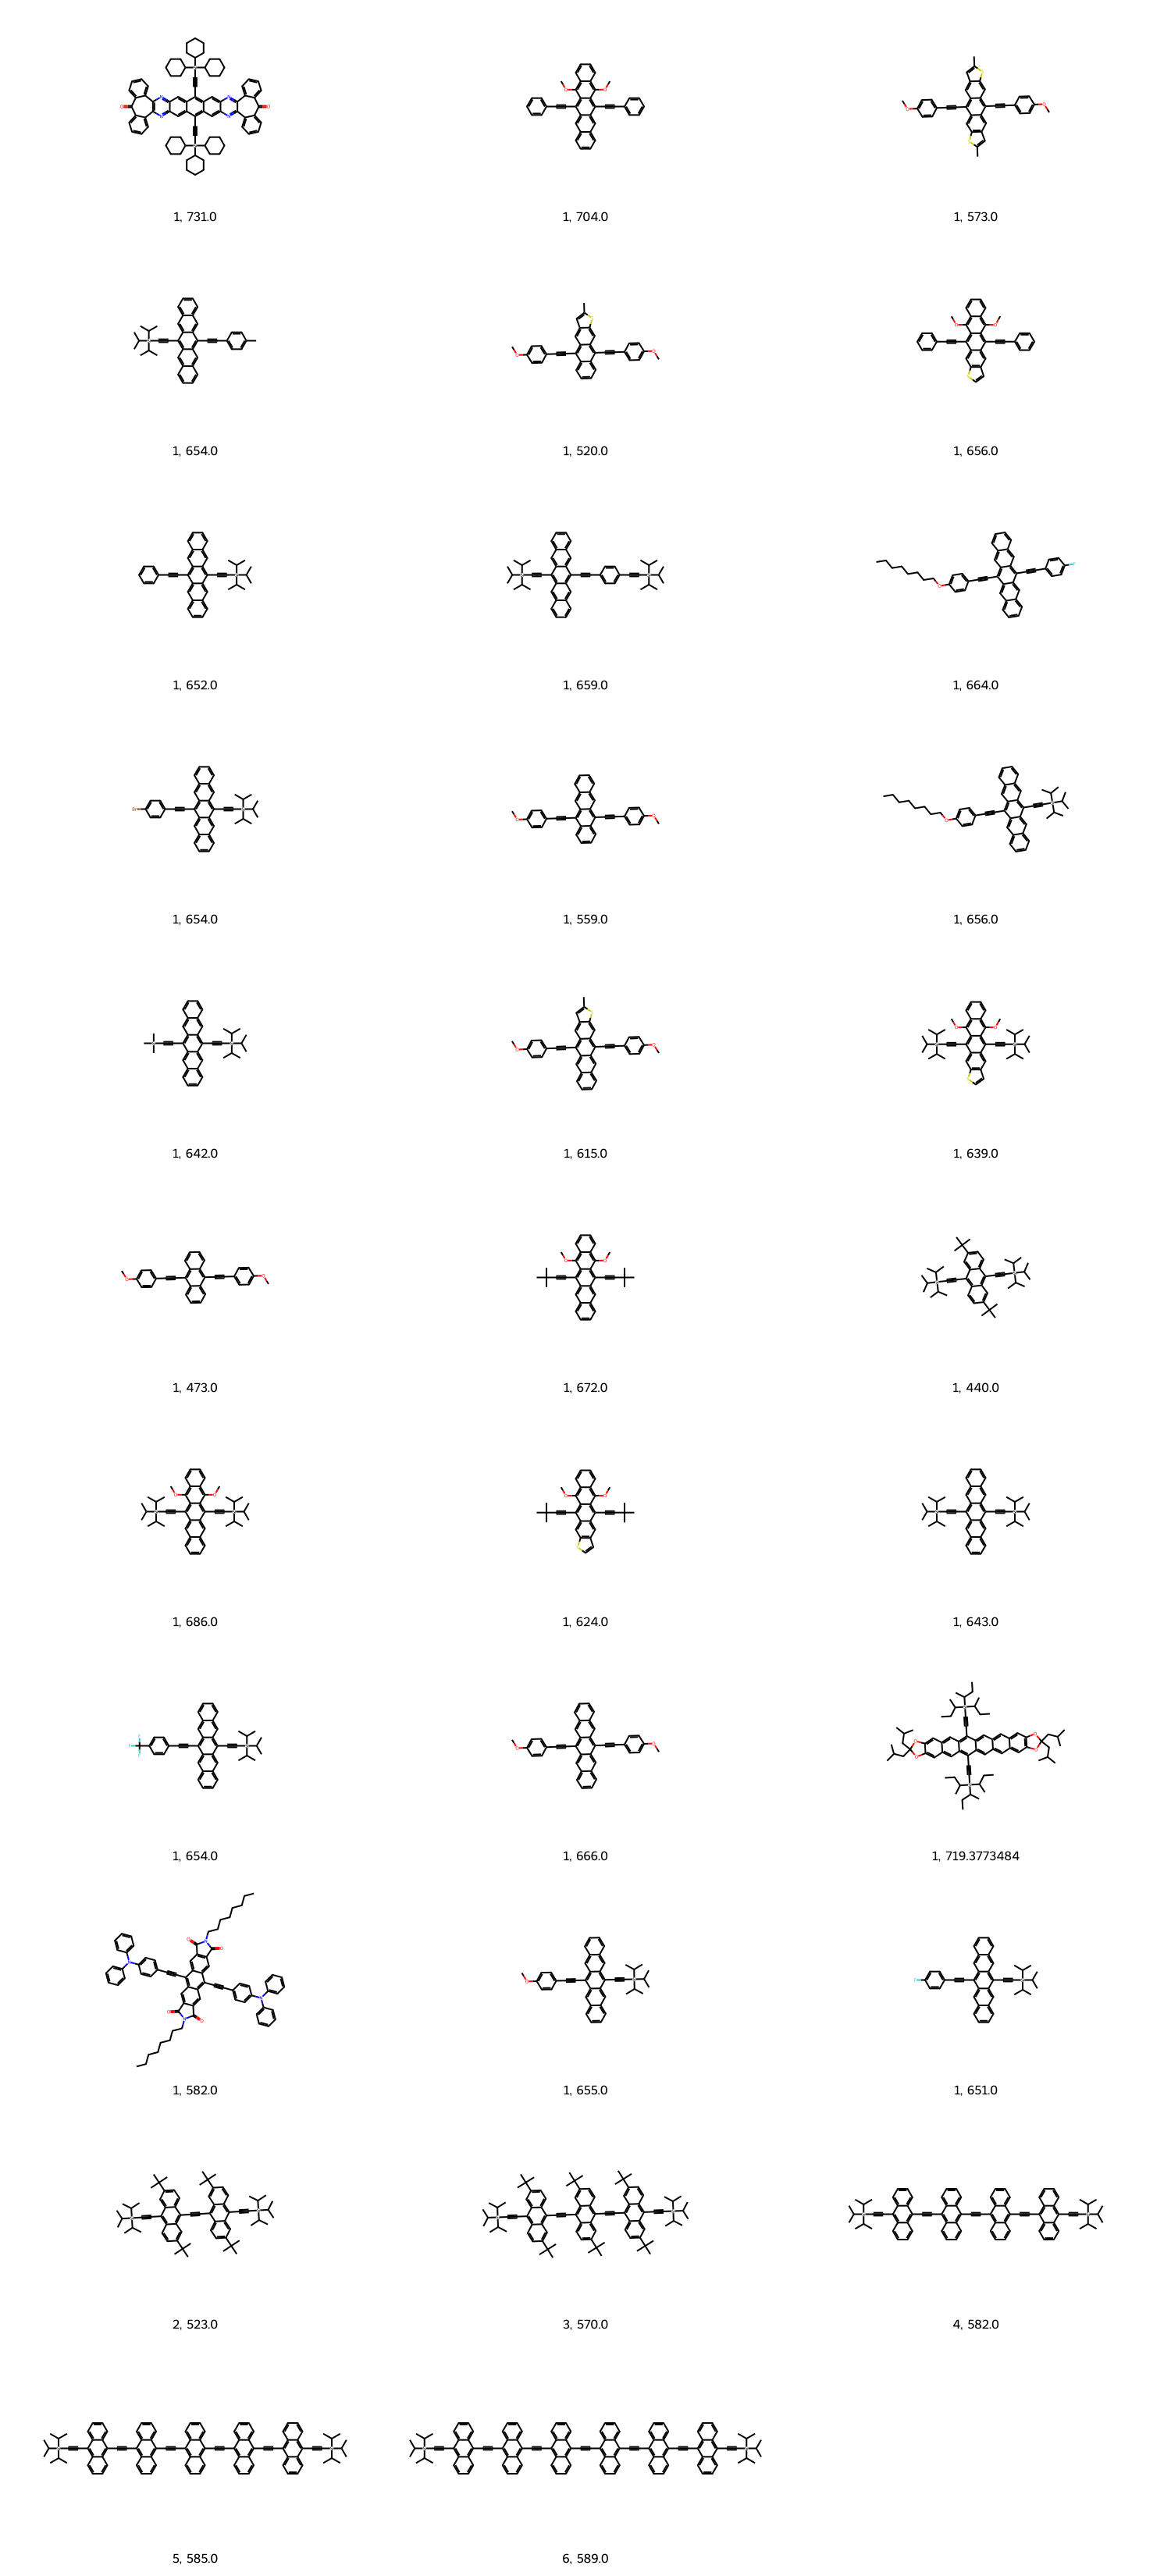

In [59]:
Draw.MolsToGridImage(
    mols = mols,
    legends = legends,
    subImgSize=(500, 300)
)

In [32]:
df_matches.plot.scatter(x="num_match", y="Absorption max (nm)")

alt.Chart(...)

In [31]:
df_matches.shrink_to_fit()
df_matches.plot.scatter(x="longest_bond_length", y="Absorption max (nm)")

alt.Chart(...)

In [ ]:
matches = df[0]["matches"].item().to_list()
for match in matches:
    print(match.sort())
matches

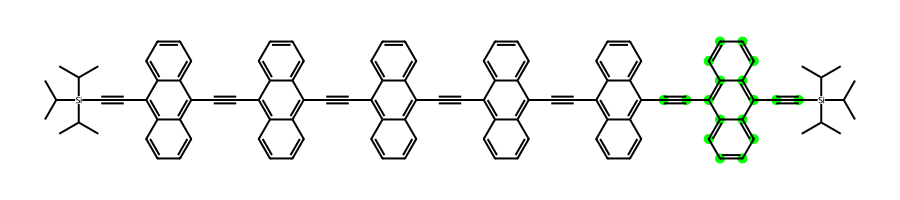

In [ ]:
smiles=df_filtered[0]["Chromophore"].item()
mol = Chem.MolFromSmiles(smiles)
Draw.MolToImage(
    mol,
    highlightAtoms=matches[0],
    highlightColor=(0,1,0),
    size=(900,200),
    useSVG=True,
    )

In [ ]:
df = df.select(pl.all().shrink_dtype())

In [ ]:
df.select(pl.all().exclude("longest_bond_indices")).write_csv("../data/DB for chromophore_Sci_Data_rev02_conjugated.csv")

In [ ]:
chromophores = df["Chromophore"].to_list()
chromophores_few = [chromophores[i] for i in [0, 1, 3, 5]] + ['c1ccccc1']
chromophores_few

IndexError: list index out of range

In [ ]:
df.sort("longest_bond_length")

Tag,Chromophore,Solvent,Absorption max (nm),Emission max (nm),Lifetime (ns),Quantum yield,log(e/mol-1 dm3 cm-1),abs FWHM (cm-1),emi FWHM (cm-1),abs FWHM (nm),emi FWHM (nm),Molecular weight (g mol-1),Reference,CanonicalSMILES,longest_bond_indices,longest_bond_length,has_match
i16,str,str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,str,str,list[i64],i16,bool
12377,"""C1C[C@H]2CC[C@@H]1N=N2""","""CC#N""",NaN,NaN,434.0,0.39,NaN,NaN,NaN,NaN,NaN,110.159401,"""DOI: 10.1021/jo990206m""","""C1C[C@H]2CC[C@@H]1N=N2""",[],0,false
12379,"""C=C[C@]12CC[C@H](CC1)N=N2""","""CC#N""",NaN,NaN,0.56,0.0009,NaN,NaN,NaN,NaN,NaN,136.197281,"""DOI: 10.1021/jo990206m""","""C=C[C@]12CC[C@H](CC1)N=N2""",[],0,false
12383,"""O=CC12N=N[C@](C=O)(C3C4CCC(C4)…","""CC#N""",NaN,NaN,111.0,0.049,NaN,NaN,NaN,NaN,NaN,298.384674,"""DOI: 10.1021/jo990206m""","""O=CC12N=N[C@](C=O)(C3C4CCC(C4)…",[],0,false
12384,"""C=CC12N=N[C@](C=C)(C3C4CCC(C4)…","""CC#N""",NaN,NaN,268.0,0.16,NaN,NaN,NaN,NaN,NaN,294.44043,"""DOI: 10.1021/jo990206m""","""C=CC12N=N[C@](C=C)(C3C4CCC(C4)…",[],0,false
12385,"""CCC12N=N[C@](CC)(C3C4CCC(C4)C3…","""CC#N""",NaN,NaN,263.0,0.19,NaN,NaN,NaN,NaN,NaN,298.472198,"""DOI: 10.1021/jo990206m""","""CCC12N=N[C@](CC)(C3C4CCC(C4)C3…",[],0,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
5663,"""Cc1ccc(-n2c(-c3ccc(N(c4ccc(-c5…","""Cc1ccc(-n2c(-c3ccc(N(c4ccc(-c5…",NaN,525.0,0.0374,NaN,NaN,NaN,NaN,NaN,140.300003,1714.100952,"""https://doi.org/10.1016/j.orge…","""Cc1ccc(-n2c(-c3ccc(N(c4ccc(-c5…","[1, 2, … 158]",155,false
5664,"""CC(C)(C)c1ccc(-n2c(-c3ccc(N(c4…","""CC(C)(C)c1ccc(-n2c(-c3ccc(N(c4…",NaN,510.0,0.138,NaN,NaN,NaN,NaN,NaN,141.100006,1882.423462,"""https://doi.org/10.1016/j.orge…","""CC(C)(C)c1ccc(-n2c(-c3ccc(N(c4…","[4, 5, … 170]",155,false
5665,"""FC(F)(F)c1ccc(-n2c(-c3ccc(N(c4…","""FC(F)(F)c1ccc(-n2c(-c3ccc(N(c4…",NaN,526.0,0.0288,NaN,NaN,NaN,NaN,NaN,149.800003,1929.981689,"""https://doi.org/10.1016/j.orge…","""FC(F)(F)c1ccc(-n2c(-c3ccc(N(c4…","[4, 5, … 170]",155,false


shape: (1, 18)
┌───────┬────────────┬───────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ Tag   ┆ Chromophor ┆ Solvent   ┆ Absorption ┆ … ┆ CanonicalS ┆ longest_b ┆ longest_b ┆ has_match │
│ ---   ┆ e          ┆ ---       ┆ max (nm)   ┆   ┆ MILES      ┆ ond_indic ┆ ond_lengt ┆ ---       │
│ i16   ┆ ---        ┆ str       ┆ ---        ┆   ┆ ---        ┆ es        ┆ h         ┆ bool      │
│       ┆ str        ┆           ┆ f32        ┆   ┆ str        ┆ ---       ┆ ---       ┆           │
│       ┆            ┆           ┆            ┆   ┆            ┆ list[i64] ┆ i16       ┆           │
╞═══════╪════════════╪═══════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 19444 ┆ CC(C)[Si]( ┆ Cc1ccccc1 ┆ 589.0      ┆ … ┆ CC(C)[Si]( ┆ [4, 5, …  ┆ 115       ┆ true      │
│       ┆ C#Cc1c2ccc ┆           ┆            ┆   ┆ C#Cc1c2ccc ┆ 134]      ┆           ┆           │
│       ┆ cc2c(C#Cc2 ┆           ┆            ┆   ┆ cc2c(C#Cc2 ┆           ┆

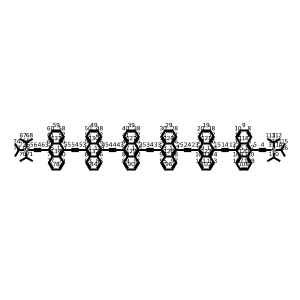

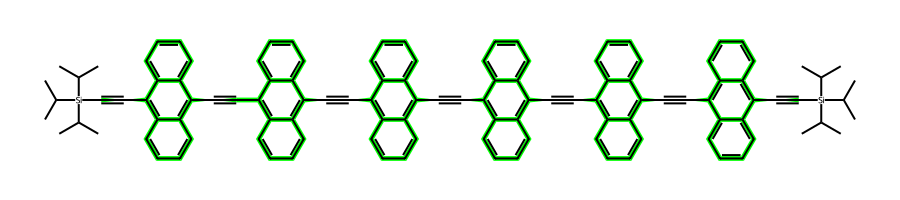

In [ ]:
# Selected molecule from optical data set
# smiles='CCCCCCCCCCCC#CC#CCCCCCCCCCN1C(=O)c2ccc3c4ccc5c6c(ccc(c7ccc(c2c37)C1=O)c64)C(=O)N(CCCCCCCCCC#CC#CCCCCCCCCCCCC)C5=O'
tag = 19444
# tag = 15096
df_filtered = df.filter(Tag=tag)
print(df_filtered)
smiles=df_filtered[0]["Chromophore"].item()
conjugated_bonds = df_filtered[0]["longest_bond_indices"].item().to_list()
print(f"{smiles=}")
print(f"{conjugated_bonds=}")
mol = Chem.MolFromSmiles(smiles)
longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
# print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")
label_bonds(mol)
Draw.MolToImage(
    mol,
    highlightBonds=conjugated_bonds,
    highlightColor=(0,1,0),
    size=(900,200),
    useSVG=True,
    )

In [ ]:
Chem.MolToSmarts(mol)

'[#6]-[#6](-[#6])-[Si](-[#6]#[#6]-[#6]1:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#6](-[#6]#[#6]-[#6]2:[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:3:[#6](-[#6]#[#6]-[#6]3:[#6]4:[#6]:[#6]:[#6]:[#6]:[#6]:4:[#6](-[#6]#[#6]-[#6]4:[#6]5:[#6]:[#6]:[#6]:[#6]:[#6]:5:[#6](-[#6]#[#6]-[#6]5:[#6]6:[#6]:[#6]:[#6]:[#6]:[#6]:6:[#6](-[#6]#[#6]-[#6]6:[#6]7:[#6]:[#6]:[#6]:[#6]:[#6]:7:[#6](-[#6]#[#6]-[Si](-[#6](-[#6])-[#6])(-[#6](-[#6])-[#6])-[#6](-[#6])-[#6]):[#6]7:[#6]:[#6]:[#6]:[#6]:[#6]:6:7):[#6]6:[#6]:[#6]:[#6]:[#6]:[#6]:5:6):[#6]5:[#6]:[#6]:[#6]:[#6]:[#6]:4:5):[#6]4:[#6]:[#6]:[#6]:[#6]:[#6]:3:4):[#6]3:[#6]:[#6]:[#6]:[#6]:[#6]:2:3):[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:1:2)(-[#6](-[#6])-[#6])-[#6](-[#6])-[#6]'

[#6]-[#6]1:[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:2:[#6](-[#6]#[#6]):[#6]2:[#6]:[#6]:[#6]:[#6]:[#6]:1:2


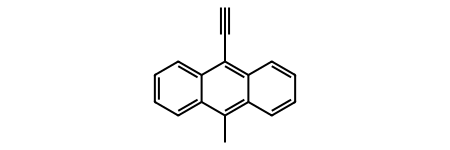

In [ ]:
# sml_unit = 'C#CC1=C2C=CC=CC2=CC2=CC=CC=C12'
sml_unit = "CC1=C2C=CC=CC2=C(C#C)C2=CC=CC=C12"
mol_unit = Chem.MolFromSmiles(sml_unit)
smarts_unit = Chem.MolToSmarts(mol_unit)
print(smarts_unit)
mol_unit

In [ ]:
mol.HasSubstructMatch(mol_unit)

True

Blank

Longest conjugated bond chain length is 15 with bond indices: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


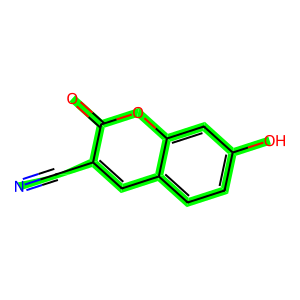

In [ ]:
# First molecule from optical data set
smiles='N#Cc1cc2ccc(O)cc2oc1=O'
mol = Chem.MolFromSmiles(smiles)
longest_conjugated_bond_chain = get_longest_conjugated_bond_chain(mol)
print(f"Longest conjugated bond chain length is {len(longest_conjugated_bond_chain)} with bond indices: {longest_conjugated_bond_chain}")

Draw.MolToImage(
    mol,
    highlightBonds=longest_conjugated_bond_chain,
    highlightColor=(0,1,0),
    )